In [1]:
import json
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, RobertaTokenizer
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math
import ast
import Levenshtein
from torch.serialization import safe_globals

In [2]:
# # Load the test dataset (expected target outputs)
# with open("../../dataset/data/python/processed_with_verdict/test.jsonl", "r") as file:
#     test_data = [json.loads(line) for i, line in enumerate(file) if i < 10]

# Load the test dataset (expected target outputs)
with open("../sample_test_set.jsonl", "r") as file:
    test_data = [json.loads(line) for i, line in enumerate(file)]

In [3]:

def safe_compile(code):
    try:
        compile(code, "<string>", "exec")
        return True
    except Exception:
        return False

def ast_similarity(code1, code2):
    try:
        tree1 = ast.dump(ast.parse(code1))
        tree2 = ast.dump(ast.parse(code2))
        return Levenshtein.ratio(tree1, tree2)
    except Exception:
        return 0.0

def evaluate_bugfix(predictions, ground_truths):
    assert len(predictions) == len(ground_truths), "Mismatch in predictions and ground truths"

    total = len(predictions)
    exact_matches = 0
    compile_success = 0
    total_lev_distance = 0
    total_ast_similarity = 0
    bleu_scores = []

    smooth_fn = SmoothingFunction().method1

    for pred, gt in zip(predictions, ground_truths):
        # Ensure pred and gt are strings, not lists
        if isinstance(pred, list):
            pred = " ".join(pred)  # Join the list into a single string
        if isinstance(gt, list):
            gt = " ".join(gt)  # Join the list into a single string

        # Now strip the strings
        if pred.strip() == gt.strip():
            exact_matches += 1

        # Compilation
        if safe_compile(pred):
            compile_success += 1

        # Levenshtein (normalized)
        lev_dist = Levenshtein.distance(pred, gt)
        total_lev_distance += lev_dist / max(len(gt), 1)

        # AST Similarity
        total_ast_similarity += ast_similarity(pred, gt)

        # BLEU
        reference = [gt.split()]
        hypothesis = pred.split()
        bleu = sentence_bleu(reference, hypothesis, smoothing_function=smooth_fn)
        bleu_scores.append(bleu)

    # Normalizing each metric to ensure they are between 0 and 1
    results = {
        "Exact Match Accuracy": (exact_matches / total),
        "Compilation Success Rate": compile_success / total,
        "Average Normalized Levenshtein Distance": total_lev_distance / total,
        "Average AST Similarity": total_ast_similarity / total,
        "Average BLEU Score": sum(bleu_scores) / total
    }

    return results


In [4]:
def evaluate_seq2seq(model, tokenizer):
    predictions = []
    ground_truths = []
    
    for entry in test_data:
        src_code = entry["src"]
        expected_output = entry["tgt"]
        
        # Tokenize the input and make predictions
        inputs = tokenizer(src_code, return_tensors="pt", truncation=True, padding=True, max_length=128)
        
        with torch.no_grad():
            output = model.generate(**inputs, max_length=128)
        
        predicted_code = tokenizer.decode(output[0], skip_special_tokens=True)
        
        predictions.append(predicted_code)
        ground_truths.append(expected_output)
        
    return evaluate_bugfix(predictions, ground_truths)


In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class CodeErrorFixModel(nn.Module):
    def __init__(self, encoder_model_name, vocab_size, embed_size=768, num_decoder_layers=6, nhead=8):
        super().__init__()
        # Load the pretrained CodeBERT encoder
        self.encoder = AutoModel.from_pretrained(encoder_model_name)
        # Decoder components
        self.decoder_embedding = nn.Embedding(vocab_size, embed_size)
        self.pos_encoder = PositionalEncoding(embed_size)
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dropout=0.1)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.embed_size = embed_size
    
    def generate_square_subsequent_mask(self, sz):
        # Create a mask to ensure that each position only attends to previous positions
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask.to(next(self.parameters()).device)
    
    def forward(self, src_input_ids, src_attention_mask, tgt_input_ids, tgt_attention_mask):
        # Encode source sequence
        encoder_outputs = self.encoder(input_ids=src_input_ids, attention_mask=src_attention_mask)
        memory = encoder_outputs.last_hidden_state  # shape: (batch_size, src_seq_len, embed_size)
        
        # Prepare target embeddings
        tgt_embeddings = self.decoder_embedding(tgt_input_ids) * math.sqrt(self.embed_size)
        tgt_embeddings = self.pos_encoder(tgt_embeddings)
        # Transformer expects (seq_len, batch_size, embed_size)
        tgt_embeddings = tgt_embeddings.transpose(0, 1)
        memory = memory.transpose(0, 1)
        
        tgt_seq_len = tgt_input_ids.size(1)
        # Create target mask for auto-regressive generation
        tgt_mask = self.generate_square_subsequent_mask(tgt_seq_len)
        
        decoder_output = self.decoder(tgt=tgt_embeddings, memory=memory, tgt_mask=tgt_mask)
        # Transpose back: (batch_size, seq_len, embed_size)
        decoder_output = decoder_output.transpose(0, 1)
        logits = self.fc_out(decoder_output)  # (batch_size, seq_len, vocab_size)
        return logits

def encode_example(example, tokenizer, max_length=512):
    src_tokens = example['src']
    tgt_tokens = example['tgt']
    src_text = " ".join(src_tokens)
    
    # Add start and end tokens to the target
    tgt_text = "<s> " + " ".join(tgt_tokens) + " </s>"
    
    src_enc = tokenizer(src_text, max_length=max_length, truncation=True, padding="max_length", return_tensors="pt")
    tgt_enc = tokenizer(tgt_text, max_length=max_length, truncation=True, padding="max_length", return_tensors="pt")
    return src_enc, tgt_enc

def pre_tokenize_data(data, tokenizer, max_length=512):
    tokenized_data = []
    src_enc, tgt_enc = encode_example(data, tokenizer, max_length)
    tokenized_data.append({
        'src_input_ids': src_enc['input_ids'].squeeze(0),
        'src_attention_mask': src_enc['attention_mask'].squeeze(0),
        'tgt_input_ids': tgt_enc['input_ids'].squeeze(0),
        'tgt_attention_mask': tgt_enc['attention_mask'].squeeze(0)
    })
    return tokenized_data

def evaluate_custom(model, tokenizer, device='cpu'):
    model.eval()
    model.to(device)

    predictions = []
    ground_truths = []

    for entry in test_data:
        tokenized_test_data = pre_tokenize_data(entry, tokenizer, max_length=512)
        test_loader = DataLoader(tokenized_test_data, batch_size=1)
        
        with torch.no_grad():
            for batch in test_loader:
                src_input_ids = batch['src_input_ids'].to(device)
                src_attention_mask = batch['src_attention_mask'].to(device)
                tgt_input_ids = batch['tgt_input_ids'].to(device)
                tgt_attention_mask = batch['tgt_attention_mask'].to(device)

                # 🔮 Predict (use teacher forcing)
                output = model(src_input_ids, src_attention_mask, tgt_input_ids[:, :-1], tgt_attention_mask[:, :-1])
                predicted_ids = output.argmax(dim=-1)

                # Decode Input (buggy), Prediction, and Target (ground truth)
                input_text = tokenizer.decode(src_input_ids[0], skip_special_tokens=True)
                predicted_text = tokenizer.decode(predicted_ids[0], skip_special_tokens=True)
                target_text = tokenizer.decode(tgt_input_ids[0], skip_special_tokens=True)

        predictions.append(predicted_text)
        ground_truths.append(target_text)
        
    return evaluate_bugfix(predictions, ground_truths)

In [28]:
accuracy = []
compilation = []
lev_distance = []
ast_score = []
bleu = []

In [29]:
# Load the model

model_path = "Salesforce/codeT5-base"  # Path to your saved model folder
print("----------------------- CodeT5 --------------------")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
codeT5_result = evaluate_seq2seq(model, tokenizer)
print(f"Results: {codeT5_result}")  

accuracy.append(codeT5_result["Exact Match Accuracy"])
compilation.append(codeT5_result["Compilation Success Rate"])
lev_distance.append(codeT5_result["Average Normalized Levenshtein Distance"])
ast_score.append(codeT5_result["Average AST Similarity"])
bleu.append(codeT5_result["Average BLEU Score"])


model_path = "../../codebert-gpt2"  # Path to your saved model folder
print("----------------------- CodeBERT-GPT2 --------------------")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
codeBERTGPT_result = evaluate_seq2seq(model, tokenizer)
print(f"Average BLEU Score: {codeBERTGPT_result}")

accuracy.append(codeBERTGPT_result["Exact Match Accuracy"])
compilation.append(codeBERTGPT_result["Compilation Success Rate"])
lev_distance.append(codeBERTGPT_result["Average Normalized Levenshtein Distance"])
ast_score.append(codeBERTGPT_result["Average AST Similarity"])
bleu.append(codeBERTGPT_result["Average BLEU Score"])

model_path = "../../codebert-codebert"  # Path to your saved model folder
print("----------------------- CodeBERT-CodeBERT --------------------")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
codeBERTBERT_result = evaluate_seq2seq(model, tokenizer)
print(f"Average BLEU Score: {codeBERTBERT_result}")

accuracy.append(codeBERTBERT_result["Exact Match Accuracy"])
compilation.append(codeBERTBERT_result["Compilation Success Rate"])
lev_distance.append(codeBERTBERT_result["Average Normalized Levenshtein Distance"])
ast_score.append(codeBERTBERT_result["Average AST Similarity"])
bleu.append(codeBERTBERT_result["Average BLEU Score"])

model_path = "../../codebert-custom/full_model.pth"  # Path to your saved model folder
print("----------------------- CodeBERT-Custom --------------------")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = torch.load(model_path, map_location="cpu", weights_only=False)
codeBERTcustom_result = evaluate_custom(model, tokenizer)
print(f"Average BLEU Score: {codeBERTcustom_result}")

accuracy.append(codeBERTcustom_result["Exact Match Accuracy"])
compilation.append(codeBERTcustom_result["Compilation Success Rate"])
lev_distance.append(codeBERTcustom_result["Average Normalized Levenshtein Distance"])
ast_score.append(codeBERTcustom_result["Average AST Similarity"])
bleu.append(codeBERTcustom_result["Average BLEU Score"])

----------------------- CodeT5 --------------------
Results: {'Exact Match Accuracy': 0.0, 'Compilation Success Rate': 0.0, 'Average Normalized Levenshtein Distance': 0.9116426496112474, 'Average AST Similarity': 0.0, 'Average BLEU Score': 8.843438725390448e-05}
----------------------- CodeBERT-GPT2 --------------------


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Average BLEU Score: {'Exact Match Accuracy': 0.0, 'Compilation Success Rate': 0.0, 'Average Normalized Levenshtein Distance': 3.23512637016851, 'Average AST Similarity': 0.0, 'Average BLEU Score': 0.04331257010379087}
----------------------- CodeBERT-CodeBERT --------------------


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Average BLEU Score: {'Exact Match Accuracy': 0.0, 'Compilation Success Rate': 0.0, 'Average Normalized Levenshtein Distance': 1.706329215346561, 'Average AST Similarity': 0.0, 'Average BLEU Score': 0.07856387931527367}
----------------------- CodeBERT-Custom --------------------
Average BLEU Score: {'Exact Match Accuracy': 0.0, 'Compilation Success Rate': 0.0, 'Average Normalized Levenshtein Distance': 11.233468898497367, 'Average AST Similarity': 0.0, 'Average BLEU Score': 0.03386395666291402}


[0.0, 0.0, 0.0, 0.0]


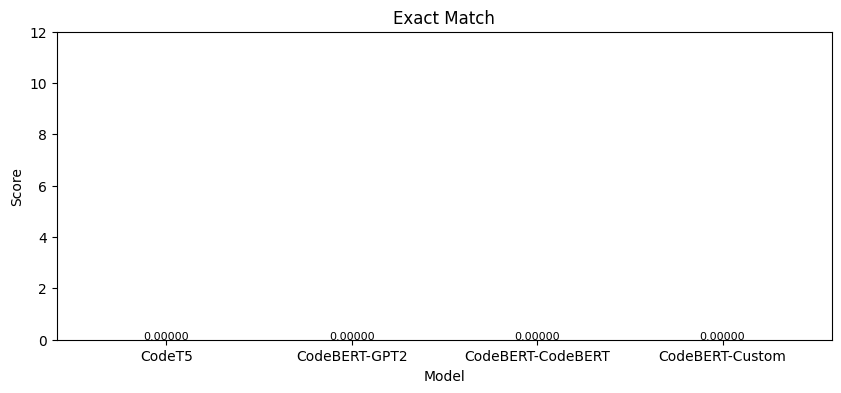

[0.0, 0.0, 0.0, 0.0]


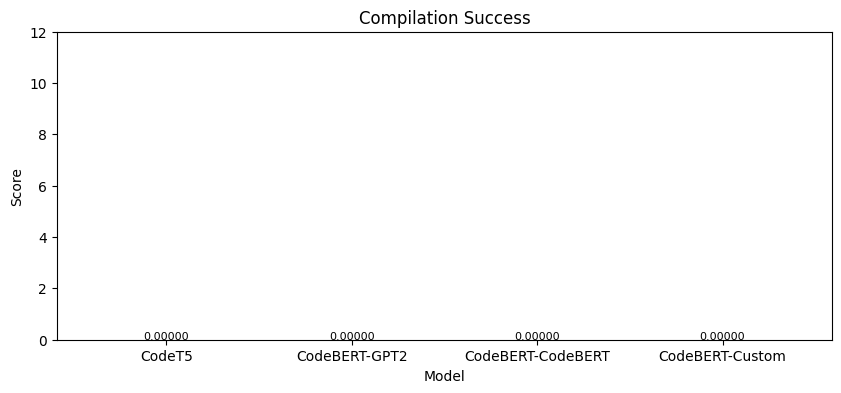

[0.9116426496112474, 3.23512637016851, 1.706329215346561, 11.233468898497367]


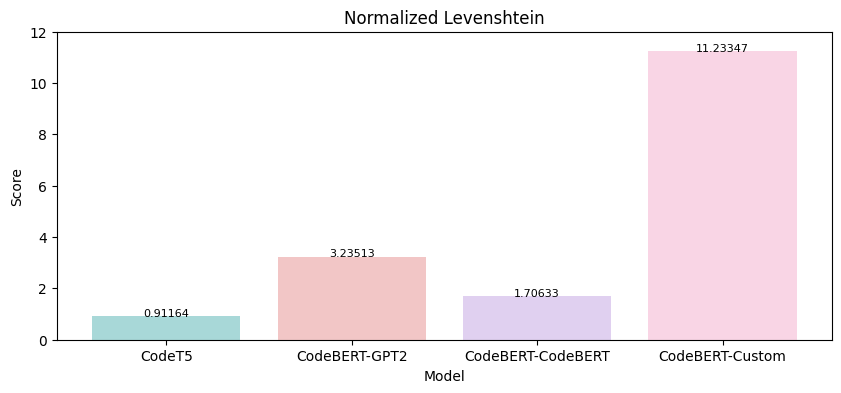

[0.0, 0.0, 0.0, 0.0]


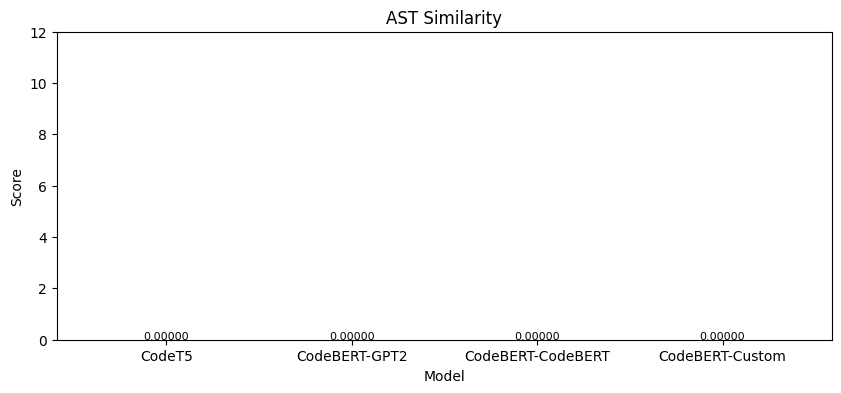

[8.843438725390448e-05, 0.04331257010379087, 0.07856387931527367, 0.03386395666291402]


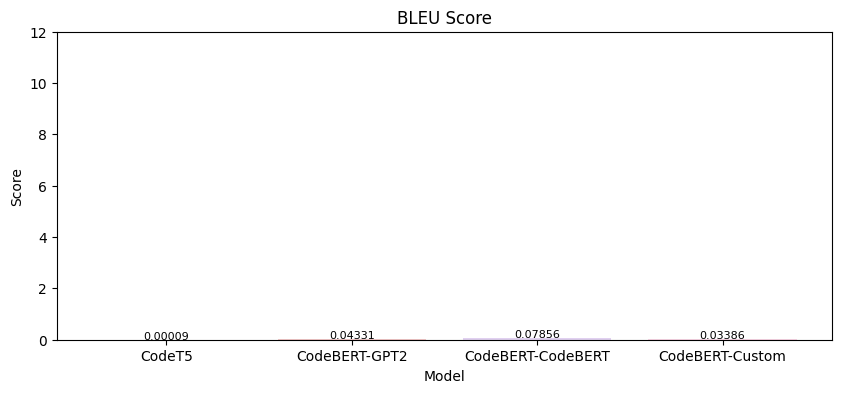

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Define models and metric values
models = ['CodeT5', 'CodeBERT-GPT2', 'CodeBERT-CodeBERT', 'CodeBERT-Custom']

# Consistent model-specific colors
model_colors = ['#A8D8D8', '#F2C6C6', '#E0D0F0', '#F9D5E5']  # You can customize these

def plot_metric(metric, title):
    print(metric)
    plt.figure(figsize=(10, 4))
    plt.bar(models, metric, color=model_colors)
    
    padding = (max(metric) - min(metric)) * 0.1
    plt.ylim(0, 12)

    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title(title)

    for i, val in enumerate(metric):
        plt.text(i, val, f'{val:.5f}', ha='center', fontsize=8)
    
    plt.show()

# Plot each metric using the shared function
plot_metric(accuracy, 'Exact Match')
plot_metric(compilation, 'Compilation Success')
plot_metric(lev_distance, 'Normalized Levenshtein')
plot_metric(ast_score, 'AST Similarity')
plot_metric(bleu, 'BLEU Score')
